In [2]:
using PGFPlots
using Distributions
using BayesNets

## Piecewise Constant Distributions

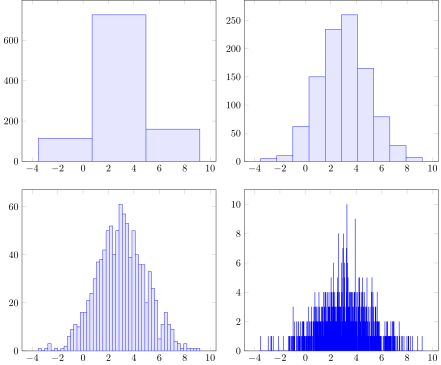

In [3]:
# define a normal distribution with mean 3 and standard deviation 2
dist = Normal(3,2)
# generate 1000 samples
d = rand(dist, 1000)
# try out histograms with a variety of different number of bins
bins = [3 10 50 1000]
g = GroupPlot(2,2)
for i = 1:length(bins)
    push!(g, Axis(Plots.Histogram(d, bins=bins[i]), ymin=0))
end
g

Of course, these plots are not of densities (they do not integrate to 1).

## Mixture Model

This example will focus on Gaussian mixture components, but the code can support components from other distributions.

In [4]:
type MixtureModel
    components
    weights    
end

In [5]:
function Distributions.pdf(d::MixtureModel, x)
    sum([d.weights[i] * pdf(d.components[i], x) for i = 1:length(d.components)])
end;

In [6]:
dist = MixtureModel([Normal(-3,1), Normal(4,2)], [0.8, 0.2])

MixtureModel([Distributions.Normal{Int64}(μ=-3, σ=1),Distributions.Normal{Int64}(μ=4, σ=2)],[0.8,0.2])

In [7]:
function Distributions.rand(d::MixtureModel, n)
    # create an array c holding random components (based on weights)
    c = wsample(1:length(d.components), d.weights, n)
    # randomly generate sample from appropriate component distribution
    [rand(d.components[c[i]]) for i = 1:n]
end;

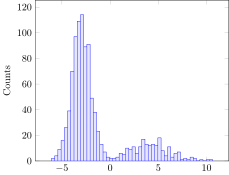

In [8]:
d = rand(dist, 1000)
a = Axis(Plots.Histogram(d, bins=50), ymin=0, ylabel="Counts")

Note the two bumps!

## Conditional Probability Distributions

### Binary

There are many types of conditional probability distributions. Here we'll focus on those with binary variables whose distribution can be specified using as table.

In [9]:
table = [
    [0,0]=>0.8,
    [0,1]=>0.2,
    [1,0]=>0.3,
    [1,1]=>0.5
]
cpd = CPDs.Bernoulli([:B, :S], table);

Let's make an assignment of variables to values.

In [10]:
a = [
    :B=>0,
    :S=>1
]

Dict{Symbol,Int64} with 2 entries:
  :S => 1
  :B => 0

In [11]:
BayesNets.pdf(cpd, a)(0)

0.8

In [12]:
rand_bernoulli_dict(2)

Dict{Array{Int64,1},Float64} with 4 entries:
  [0,1] => 0.69
  [1,0] => 0.02
  [1,1] => 0.76
  [0,0] => 0.6

### Linear Gaussian

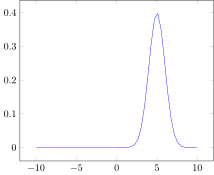

In [13]:
# The constructor of CPDs.Normal takes a function mapping an assignment to
# a tuple of parameters (i.e., mean and variance) for the Normal distribution
cpd = CPDs.Normal(a -> (5a[:B], 1)) # mean is 5b, variance is 1
# plot p(*|B=1)
a = [:B=>1] # assignment setting B = 1
Plots.Linear(BayesNets.pdf(cpd, a), (-10, 10))

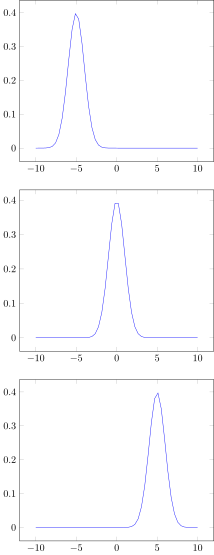

In [14]:
g = GroupPlot(1,3)
for b in -1:1
    push!(g, Plots.Linear(BayesNets.pdf(cpd, [:B=>b]), (-10, 10)))
end
g

## Bayesian Networks

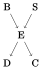

In [15]:
b = BayesNet([:B, :S, :E, :D, :C])
add_edges!(b, [(:B, :E), (:S, :E), (:E, :D), (:E, :C)])

We need to set the CPDs for each of the nodes.

In [16]:
set_CPD!(b, :B, CPDs.Bernoulli(0.1))
set_CPD!(b, :S, CPDs.Bernoulli(0.5))
set_CPD!(b, :E, CPDs.Bernoulli([:B, :S], rand_bernoulli_dict(2)))
set_CPD!(b, :D, CPDs.Bernoulli([:E], rand_bernoulli_dict(1)))
set_CPD!(b, :C, CPDs.Bernoulli([:E], rand_bernoulli_dict(1)));

Let's compute the probability of an assignment using the chain rule.

In [17]:
a = [
    :B=>0,
    :S=>1,
    :E=>0,
    :D=>1,
    :C=>1
]

Dict{Symbol,Int64} with 5 entries:
  :S => 1
  :C => 1
  :B => 0
  :D => 1
  :E => 0

Here are the conditional probabilities.

In [18]:
[BayesNets.pdf(b.nodes[i].cpd, a)(a[names(b)[i]]) for i = 1:length(names(b))]

5-element Array{Any,1}:
 0.9 
 0.5 
 0.4 
 0.47
 0.13

In [19]:
prod([BayesNets.pdf(b.nodes[i].cpd, a)(a[names(b)[i]]) for i = 1:length(names(b))])

0.010998

The library does this for you using the function prob.

In [20]:
prob(b, a)

0.010998